# Potential of remotely sensed datasets
***

**Author:** *Chus Casado Rodríguez*<br>
**Date:** *22-01-2026*<br>

**Introduction:**<br>
I compare the volume time series estimated by the Global Water Watch with the observed time series from ResOpsUS.

**Ideas:**<br>

In [ ]:
import numpy as np
import pandas as pd
import geopandas as gpd
import rioxarray as rxr
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns
from tqdm.auto import tqdm

%matplotlib inline
plt.rcParams.update({'font.size': 12})

from reservoirs_lshm import Config, read_attributes, read_timeseries
from reservoirs_lshm.models.basemodel import Reservoir
from reservoirs_lshm.utils.metrics import KGEmod
from reservoirs_lshm.utils.plots import plot_timeseries
from utils import map_performance

## Config

In [2]:
country = 'US'
long_name = 'United States'

path_datasets = Path('/home/casadoj/datasets/reservoirs')

path_plots = Path('./plots/')
path_plots.mkdir(exist_ok=True)

# load configuration file
cfg = Config(path_datasets / 'ResOpsUS/v2.1/results_before_GRanD_correction/mhm/mhm_storage.yml')

path_paper = Path('../../../docs/paper/draft/figures')
print(f'Results will be saved in {path_paper}')

Results will be saved in ../../../docs/paper/draft/figures


## Data

### Base layers

In [3]:
# load GloFAS' elevation and upstream area map
elevation = rxr.open_rasterio(cfg.PATH_DATA.parent / 'GIS' / 'elv_3min_US.tif', masked=True).squeeze('band')
uparea = rxr.open_rasterio(cfg.PATH_DATA.parent / 'GIS' / 'upArea_3min_US.tif', masked=True).squeeze('band')

### ResOpsUS

In [4]:
path_resops = path_datasets / 'ResOpsUS' / 'v2.2'


#### Attributes

In [5]:
# list of selected reservoirs
res_list = pd.read_csv(cfg.RESERVOIRS_FILE, header=None).squeeze().tolist()

# load reservoir resops_attrs
resops_attrs = read_attributes(
    path=cfg.PATH_DATA / 'attributes', 
    reservoirs=res_list
    )
resops_attrs.columns = resops_attrs.columns.str.lower()
resops_attrs = gpd.GeoDataFrame(
    resops_attrs,
    geometry=gpd.points_from_xy(resops_attrs.lon, resops_attrs.lat),
    crs='epsg:4326'
)
print(f'{len(resops_attrs)} reservoirs in the attributes table')

164 reservoirs in the attributes table


#### Time series

In [6]:
# load time series
resops_ts = read_timeseries(
    path=cfg.PATH_DATA / 'time_series' / 'csv',
    reservoirs=resops_attrs.index,
    variables=['elevation', 'storage']
)
# keep only reservoirs with storage data
compulsory = ['storage'] #['elevation', 'storage']
resops_ts = {
    grand_id: df for grand_id, df in resops_ts.items() 
    if all(col in df.columns for col in compulsory)
    }
print(f'{len(resops_ts)} reservoirs with time series in ResOpsUS')
with_elevation = pd.Series({grand_id: True if 'elevation' in ts.columns else False for grand_id, ts in resops_ts.items()})
with_storage = pd.Series({grand_id: True if 'storage' in ts.columns else False for grand_id, ts in resops_ts.items()})
print(f'\t{sum(with_elevation)} with elevation time series')
print(f'\t{sum(with_storage)} with storage time series')
print(f'\t{sum(with_storage & with_elevation)} with elevation and storage time series')

  0%|          | 0/164 [00:00<?, ?it/s]

Time series for ID 55 is missing variables: {'elevation'}
Time series for ID 57 is missing variables: {'elevation'}
Time series for ID 60 is missing variables: {'elevation'}
Time series for ID 63 is missing variables: {'elevation'}
Time series for ID 131 is missing variables: {'elevation'}
Time series for ID 132 is missing variables: {'elevation'}
Time series for ID 133 is missing variables: {'elevation'}
Time series for ID 148 is missing variables: {'elevation'}
Time series for ID 180 is missing variables: {'elevation'}
Time series for ID 191 is missing variables: {'elevation'}
Time series for ID 193 is missing variables: {'elevation'}
Time series for ID 198 is missing variables: {'elevation'}
Time series for ID 214 is missing variables: {'elevation'}
Time series for ID 297 is missing variables: {'elevation'}
Time series for ID 361 is missing variables: {'elevation'}
Time series for ID 367 is missing variables: {'elevation'}
Time series for ID 372 is missing variables: {'elevation'}
T

### NID: National Inventory of Dams

I created an Excel file with the storage capacity, maximum water surface and dam height reported by the National Inventory of Dams for the 164 reservoirs in the study.

In [ ]:
nid = pd.read_excel(
    'check_attributes.xlsx', 
    index_col='GRAND_ID', 
    usecols=['GRAND_ID', 'cap_mcm_nid', 'area_skm_nid', 'dam_hgt_m_nid']
    )
nid.columns = [col[:-4] for col in nid.columns]
nid.sort_index(inplace=True)
rounding = {
    'cap_mcm': 1,
    'area_skm': 3,
    'dam_hgt_m': 0,
}
for col, decimals in rounding.items():
    nid[col] = nid[col].round(decimals)

nid.head(2)

,cap_mcm,area_skm,dam_hgt_m
GRAND_ID,,,
41,1791.9,47.267,165.0
55,194.9,10.368,39.0


```Python
# plot time series of storage and elevation
PATH_PLOTS = Path(cfg.PATH_DATA / 'time_series' / 'plots' / 'storage_vs_elevation')
PATH_PLOTS.mkdir(exist_ok=True)
for grand_id, ts in tqdm(timeseries.items()):
    cap_mcm, elev_masl, dam_hgt_m = nid.loc[grand_id, ['cap_mcm', 'elev_masl', 'dam_hgt_m']]
    plot_timeseries(
        ts, 
        cap_mcm, 
        elev_masl, 
        dam_hgt_m, 
        save=PATH_PLOTS / f'{grand_id}.jpg'
    )
```

### Global Dam Watch

In [ ]:
# load GDW reservoirs in the country
path_gdw = path_datasets / 'GDW' / 'GDW_v1_0_shp'
gdw = gpd.read_file(path_gdw / 'GDW_barriers_v1_0.shp')
# set the index
gdw = gdw[gdw.GRAND_ID.notnull()]
gdw.set_index('GRAND_ID', drop=True, inplace=True)
gdw.sort_index(axis=0, inplace=True)
gdw.index = gdw.index.astype(int)
gdw = gdw[gdw.COUNTRY == long_name]
gdw.columns = gdw.columns.str.lower()
print(f'GDW contains {len(gdw)} reservoirs in {long_name}')

# reduce reservoirs to those i<n both GDW and ResOps datasets
grand_ids = gdw.index.intersection(resops_ts.keys())
gdw = gdw.loc[grand_ids]
resops_ts = {grand_id: resops_ts[grand_id] for grand_id in grand_ids}
print(f'{len(grand_ids)} are both in GDW and ResOps datasets')

GDW contains 1915 reservoirs in United States
164 are both in GDW and ResOps datasets


### GRanD

In [9]:
# load GRamD reservoirs in the country
PATH_GRAND = path_datasets / 'GRanD' / 'v1_3'
grand = gpd.read_file(PATH_GRAND / 'GRanD_dams_v1_3.shp').set_index('GRAND_ID')
grand = grand[grand.COUNTRY == long_name]
grand.columns = grand.columns.str.lower()
print(f'GRanD contains {len(grand)} reservoirs in {long_name}')

# reduce reservoirs to those i<n both GRanD and ResOps datasets
grand_ids = grand.index.intersection(resops_ts.keys())
grand = grand.loc[grand_ids]
resops_ts = {grand_id: resops_ts[grand_id] for grand_id in grand_ids}
print(f'{len(grand_ids)} are both in GDW and ResOps datasets')

GRanD contains 1920 reservoirs in United States
164 are both in GDW and ResOps datasets


### Global Water Watch

In [10]:
path_gww = path_datasets / 'GWW'

#### Attributes

In [11]:
# load GWW attribute shapefile
gww_attrs = gpd.read_file(path_gww / 'GIS' / f'gww_{country}.shp').set_index('grand_id')
grand_ids = gww_attrs.index.intersection(gdw.index)
gww_attrs = gww_attrs.loc[grand_ids]
print(f'{len(gww_attrs)} reservoirs are in GWW and GDW')

173 reservoirs are in GWW and GDW


#### Time series

In [115]:
# load time series
gww_ts = {}
for grand_id in tqdm(set(gww_attrs.index)):
    try:
        gww_id = gww_attrs.loc[grand_id, 'gww_id'].item()
    except:
        print(f'Multiple intances of GRanD ID {grand_id} in GWW')
        continue

    csv_file = path_gww / 'time_series' / 'raw' / f'{gww_id}.csv'
    if csv_file.is_file():
        # import time series from CSV
        ts = pd.read_csv(csv_file, parse_dates=True, index_col=0)
        # adapt
        ts.rename(columns={'volume_mcm': 'storage', 'area_skm': 'area'}, inplace=True)
        # convert units
        ts *= 1e6
        # if 'storage' in ts.columns:
        #     ts.storage *= 1e6
        # if 'area' in ts.columns:
        #     ts.area *= 1e6
        ts = ts.resample('D').mean()
        ts.index.name = 'date'
        # save
        gww_ts[grand_id] = ts

print(f'\n{len(gww_ts)} reservoirs have time series in GWW')
with_area = pd.Series({grand_id: True if 'area' in ts.columns else False for grand_id, ts in gww_ts.items()})
with_storage = pd.Series({grand_id: True if 'storage' in ts.columns else False for grand_id, ts in gww_ts.items()})
print(f'\t{sum(with_area)} with area time series')
print(f'\t{sum(with_storage)} with storage time series')
print(f'\t{sum(with_storage & with_area)} with area and storage time series')

  0%|          | 0/164 [00:00<?, ?it/s]

Multiple intances of GRanD ID 1033 in GWW
Multiple intances of GRanD ID 597 in GWW
Multiple intances of GRanD ID 1207 in GWW
Multiple intances of GRanD ID 1796 in GWW
Multiple intances of GRanD ID 1872 in GWW
Multiple intances of GRanD ID 870 in GWW
Multiple intances of GRanD ID 989 in GWW

157 reservoirs have time series in GWW
	157 with area time series
	12 with storage time series
	12 with area and storage time series


## Analysis

### Reservoir shape

In this part, I validate how accurate is the reservoir shape we assumed (inverted half pyramid) by generating a time series of reservoir elevation from the time series of observed volume. The estimated elevations are compared agains the observed to assess the validity of the assumption.

In [79]:
perf_elevation = pd.DataFrame(columns=['KGE', 'variability', 'bias', 'correlation'], dtype=float)
perf_elevation.index.name = 'GRAND_ID'

for grand_id, ts in tqdm(resops_ts.items()):
    if 'elevation' not in ts.columns:
        continue

    # extract attributes
    cols = ['cap_mcm', 'dam_hgt_m', 'area_skm'] #, 'elev_masl'
    # cap_mcm, dam_hgt_m, elev_masl, area_skm = resops_attrs.loc[grand_id, cols]
    # cap_mcm, dam_hgt_m, elev_masl, area_skm = gdw.loc[grand_id, cols]
    # cap_mcm, dam_hgt_m, elev_masl, area_skm = grand.loc[grand_id, cols]
    cap_mcm, dam_hgt_m, area_skm = nid.loc[grand_id, cols]
    elev_masl = grand.loc[grand_id, 'elev_masl']

    # declare reservoir
    res = Reservoir(Vmin=0, Vtot=cap_mcm * 1e6, Atot=area_skm * 1e6)

    # estimate elevation time series
    elev_sim = res.estimate_level(ts.storage, elev_masl, dam_hgt_m)
    perf_elevation.loc[grand_id] = KGEmod(ts.elevation, elev_sim)

    # # estimate reservoir area
    # area_sim = res.estimate_area(ts.storage)

perf_elevation.index = perf_elevation.index.astype(int)
resops_attrs['kge_z'] = perf_elevation.KGE

  0%|          | 0/164 [00:00<?, ?it/s]

In [80]:
perf_elevation.describe()

,KGE,variability,bias,correlation
count,138.000000,138.000000,138.000000,138.000000
mean,0.580396,1.282461,0.992398,0.950091
std,0.393627,0.454367,0.098385,0.182297
min,-1.565826,0.004269,0.010365,-0.132000
25%,0.480133,1.078052,0.992964,0.987667
50%,0.696521,1.258342,0.999635,0.998387
75%,0.822626,1.469913,1.005968,0.999763
max,0.999079,3.536105,1.438042,0.999999


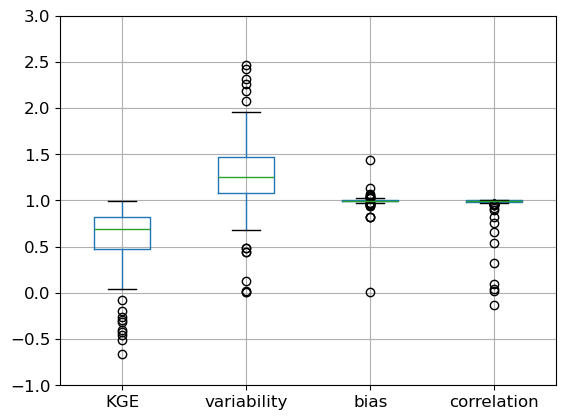

In [81]:
perf_elevation.boxplot()
plt.ylim(-1, 3)
plt.show()

#### Map

138


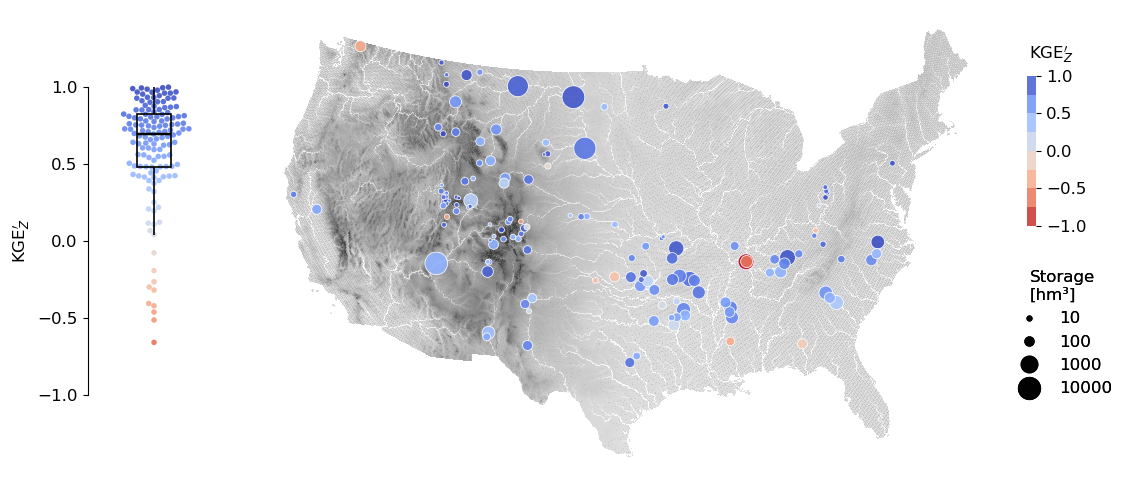

In [86]:
# select reservoirs
col_perf = 'kge_z'
reservoirs = resops_attrs[resops_attrs[col_perf].notnull()]
print(len(reservoirs))

map_performance(
    reservoirs,
    'cap_mcm',
    col_perf,
    elevation,
    uparea,
    extent=[-122, -74, 25, 50],
    proj='epsg:9311',
    alpha=.9,
    metric=r"$\text{KGE}_Z'$",
    save=path_paper / 'kge_elevation_epsg9311.pdf'
)

### Comparison with GWW time series

#### Volume time series

In [116]:
perf_gww = pd.DataFrame(columns=['KGE', 'variability', 'bias', 'correlation'], dtype=float)
perf_gww.index.name = 'GRAND_ID'

grand_ids = []
for grand_id, ts in gww_ts.items():
    if 'storage' not in ts.columns:
        continue
    else:
        grand_ids.append(grand_id)
    
    # extract observed time series
    obs = resops_ts[grand_id]
    
    # performance
    perf_gww.loc[grand_id] = KGEmod(obs.storage, ts.storage)
resops_attrs['kge_gww'] = perf_gww.KGE

In [118]:
perf_gww.describe()

,KGE,variability,bias,correlation
count,12.000000,12.000000,12.000000,12.000000
mean,0.611317,0.892561,1.180152,0.838259
std,0.213520,0.260577,0.209001,0.149270
min,0.214546,0.550233,0.991371,0.449997
25%,0.507529,0.683218,1.046458,0.815249
50%,0.649813,0.912644,1.123820,0.876829
75%,0.779444,1.054491,1.176550,0.924987
max,0.835029,1.260879,1.673424,0.987569


12 reservoirs


<Axes: >

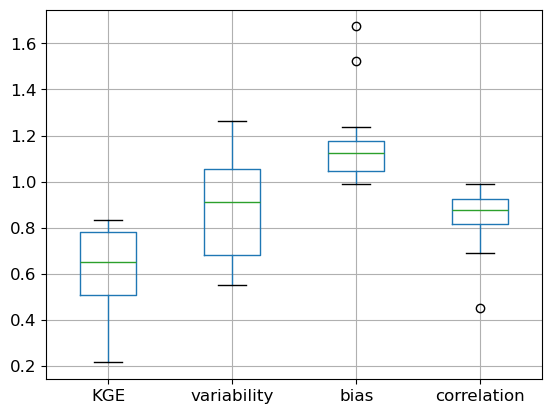

In [92]:
print(len(perf_gww), 'reservoirs')
perf_gww.boxplot()

12


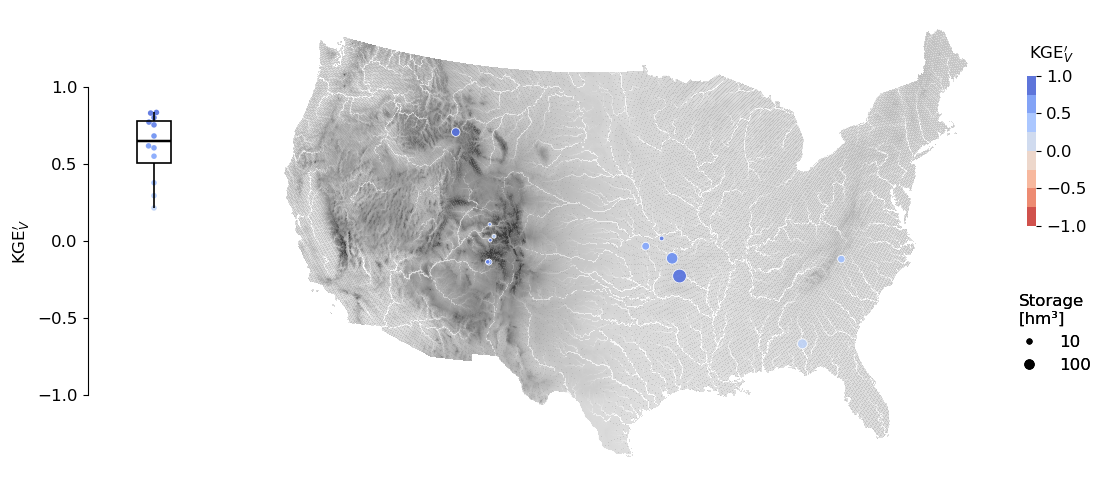

In [148]:
# column that defines performance
col_perf = 'kge_gww'
# dataframe to be plotted
reservoirs = resops_attrs[resops_attrs[col_perf].notnull()]
print(len(reservoirs))

map_performance(
    reservoirs,
    'cap_mcm',
    col_perf,
    elevation,
    uparea,
    extent=[-122, -74, 25, 50],
    proj='epsg:9311',
    alpha=.9,
    metric=r"$\text{KGE}_V'$",
    save=path_paper / 'kge_storage_gww_epsg9311.pdf'
)